In [1]:
import csv
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline

In [2]:
# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader, None)  # skip the headers        
        for line in reader:
            (Id, Text, Label, Rating, Verified) = parseReview(line)
            rawData.append((Id, Text, Label, Rating, Verified))
#             preprocessedData.append((Id, preProcess(Text), Label))
        

In [3]:
# QUESTION 1
def parse_label(label):
    if label == '__label2__':
        return 'real'
    else:
        return 'fake'    

def parse_verification(label):
    if label == 'N':
        return 0
    else:
        return 1      

# Convert line from input file into an id/text/label tuple
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    return (reviewLine[0], \
            reviewLine[8] + ' ' + reviewLine[7], \
            parse_label(reviewLine[1]), \
            reviewLine[2], \
            parse_verification(reviewLine[3]))
        

In [4]:
from __future__ import unicode_literals

import re, string
import nltk
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop = set(stopwords.words('english'))
s = nltk.stem.SnowballStemmer('english')
l = WordNetLemmatizer()
translator=str.maketrans('','',string.punctuation)

# Input: a string of one review
def preProcess(text):  
    text = re.sub(r"(\w)([.,;:!-?'\"”\)])", r"\1 \2", text)
    text = re.sub(r"([.,;:!-?'\"“\(])(\w)", r"\1 \2", text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.translate(translator)
    text = text.lower()    
    tokens = word_tokenize(text)
    tokens = [l.lemmatize(t) for t in tokens]
#     tokens = [s.stem(t) for t in tokens]    
    tokens = [t for t in tokens if t not in stop]
    return tokens

In [5]:
# QUESTION 2
featureDict = {} # A global dictionary of features

def toFeatureVector(tokens, rating, verified):
    # Should return a dictionary containing features as keys, and weights as values
    v = {}
    for t in tokens:
        try:
            featureDict[t] += 1
        except KeyError:            
            featureDict[t] = 1
        try:
            v[t] += (1.0/len(tokens))
        except KeyError:
            v[t] = (1.0/len(tokens))
    v['Rating'] = rating
    v['Verified'] = verified    
    return v

In [6]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

In [7]:
# QUESTION 3

def crossValidate(dataset, folds):
    shuffle(dataset)
    predictions = []
    ground_truth = []
    foldSize = int(len(dataset)/folds)
    #preProcess and tokenize once!
    dataset = [(t[0], preProcess(t[1]), t[2], t[3], t[4]) for t in dataset]
    dataset = [(t[0], toFeatureVector(t[1], t[3], t[4]), t[2]) for t in dataset]    
    
    for i in range(0,len(dataset), foldSize):
        trainFolds = dataset[:i] + dataset[i+foldSize:]        
        validationFold = dataset[i: i+foldSize]
        
        training_set = [(t[1], t[2]) for t in trainFolds]
        classifier = trainClassifier(training_set)
        validation_set = [(t[0], t[1]) for t in validationFold]
        predictions.append(predictLabels(validationFold, classifier))
        ground_truth.append([ l[2] for l in validationFold])
        
    return ground_truth, predictions

In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[1], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [9]:
def flatten(lst):
    for el in lst:
        if isinstance(el, list):
            yield from el
        else:
            yield el

In [12]:
# MAIN
import time
start_time = time.time()

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# loading reviews
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData" % (len(rawData), len(trainData)),
      "Preparing the dataset...",sep='\n')
loadData(reviewPath) 
print("Now %d rawData, %d trainData" % (len(rawData), len(trainData)),
      "Preparing the dataset...",sep='\n')

ground_truth, predictions = crossValidate(rawData, 10)
ground_truth = list(flatten(ground_truth))
predictions = list(flatten(predictions))

# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData" % (len(rawData), len(trainData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print('Accuracy: ' + str(round(100*accuracy_score(ground_truth, predictions), 2)))
print(metrics.classification_report(ground_truth, predictions))

print("--- %s seconds ---" % (time.time() - start_time))

Now 0 rawData, 0 trainData
Preparing the dataset...
Now 21000 rawData, 0 trainData
Preparing the dataset...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Now 21000 rawData, 0 trainData
Training Samples: 
0
Features: 
29985
Accuracy: 78.96
             precision    recall  f1-score   support

       fake       0.81      0.75      0.78     10500
       real       0.77      0.83      0.80     10500

avg / total       0.79      0.79      0.79     21000

--- 39.56807589530945 seconds ---


In [144]:
import pandas as pd
names = ['doc_id', 'label', 'rating', 'verified_purchase', \
         'pr_category', 'pr_id', 'pr_title', 'review_title', 'review_text']
data = pd.read_csv('amazon_reviews.txt', skiprows=[0], names=names, sep='\t')
data['verified_purchase'] = data['verified_purchase'].apply(lambda x: 1 if x=='Y' else 0)
data['label'] = data['label'].apply(lambda x: 'real' if x=='__label2__' else 'fake')
data['review_text_length'] = data.apply(lambda row: len(row.review_text), axis=1)

In [133]:
data.dtypes#.describe()

doc_id                 int64
label                 object
rating                 int64
verified_purchase      int64
pr_category           object
pr_id                 object
pr_title              object
review_title          object
review_text           object
review_text_length     int64
dtype: object

In [145]:

data.head()

,doc_id,label,rating,verified_purchase,pr_category,pr_id,pr_title,review_title,review_text,review_text_length
0,1,fake,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",116
1,2,fake,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,404
2,3,fake,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,248
3,4,fake,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,212
4,5,fake,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,331


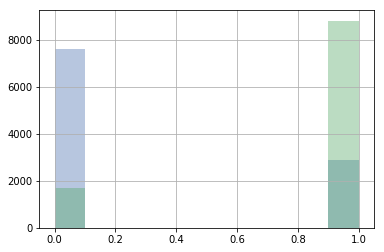

In [147]:
import matplotlib.pyplot as plt

# data.groupby('label').verified_purchase.plot(kind='kde')
data.groupby('label').verified_purchase.hist(alpha=0.4, label=['x', 'y'])
plt.show()


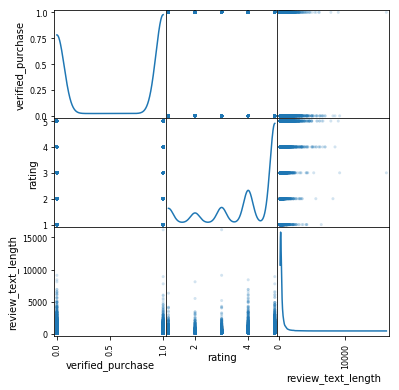

In [112]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['label','verified_purchase', 'rating', 'review_text_length']], alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

In [128]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

# Construct the scatter plot

p = figure(data, x='rating', y='verified_purchase', color="label", title="Rating vs Verified")


DAYS = ['Sun', 'Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon']

p = figure(plot_width=800, plot_height=300, y_range=DAYS, x_axis_type='datetime',
           title="Commits by Time of Day (US/Central) 2012—2016")

# Output the file 
output_file('scatter.html')

# Show the scatter plot
show(p)

W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='0c6d8e9a-5862-44a7-a5ac-db140e7275bb', ...)


In [137]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral5
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap

output_file("bars.html")

group = data.groupby('label')

source = ColumnDataSource(group)
index_cmap = factor_cmap('label', palette=Spectral5, factors=sorted(data.label.unique()), end=1)

p = figure(plot_width=800, plot_height=300, title="Mean MPG by # Cylinders and Manufacturer",
           x_range=group, toolbar_location=None, tools="")

p.vbar(x='label', top='verified_purchase', width=1, source=source,
       line_color="white", fill_color=index_cmap, )

p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Manufacturer grouped by # Cylinders"
p.xaxis.major_label_orientation = 1.2
p.outline_line_color = None

# p.add_tools(HoverTool(tooltips=[("MPG", "@mpg_mean"), ("Cyl, Mfr", "@cyl_mfr")]))

show(p)

W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='0c6d8e9a-5862-44a7-a5ac-db140e7275bb', ...)
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: mpg_mean [renderer: GlyphRenderer(id='3729e570-1ad5-4c99-aabc-c3cc4f9c595b', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: mpg_mean [renderer: GlyphRenderer(id='9c67f556-b409-4c87-b312-82347d713df1', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: verified_purchase [renderer: GlyphRenderer(id='0d63fce7-80c4-4dc1-8375-da9b1ee5be39', ...)]


In [135]:
# data.head()

In [140]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral5
from bokeh.sampledata.autompg import autompg_clean as df
from bokeh.transform import factor_cmap

output_file("bars.html")

df.cyl = df.cyl.astype(str)
df.yr = df.yr.astype(str)

group = df.groupby(('cyl', 'mfr'))

source = ColumnDataSource(group)
index_cmap = factor_cmap('cyl_mfr', palette=Spectral5, factors=sorted(df.cyl.unique()), end=1)

p = figure(plot_width=800, plot_height=300, title="Mean MPG by # Cylinders and Manufacturer",
           x_range=group, toolbar_location=None, tools="")

p.vbar(x='cyl_mfr', top='mpg_mean', width=1, source=source,
       line_color="white", fill_color=index_cmap, )

p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Manufacturer grouped by # Cylinders"
p.xaxis.major_label_orientation = 1.2
p.outline_line_color = None

p.add_tools(HoverTool(tooltips=[("MPG", "@mpg_mean"), ("Cyl, Mfr", "@cyl_mfr")]))

show(p)

W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='0c6d8e9a-5862-44a7-a5ac-db140e7275bb', ...)
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: mpg_mean [renderer: GlyphRenderer(id='3729e570-1ad5-4c99-aabc-c3cc4f9c595b', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: mpg_mean [renderer: GlyphRenderer(id='9c67f556-b409-4c87-b312-82347d713df1', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: verified_purchase [renderer: GlyphRenderer(id='0d63fce7-80c4-4dc1-8375-da9b1ee5be39', ...)]


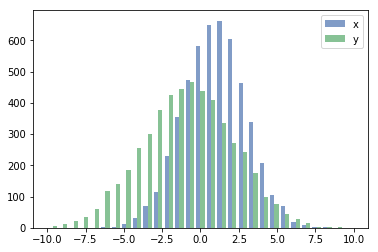

In [142]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

x = np.random.normal(1, 2, 5000)
y = np.random.normal(-1, 3, 5000)
# data = np.vstack([x, y]).T
bins = np.linspace(-10, 10, 30)

plt.hist(data, bins, alpha=0.7, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()